In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import sys
sys.path.append('/mnt/Data/ownCloud/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/')

In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as pl
import pickle as pkl
import Recordings
import signale,trajectory
import extras.trees
import os,sys
import fnmatch
import colormaps as cmaps
import seaborn as sns
import scipy.signal as scsig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def locate(pattern, root=os.curdir):
    '''
    Locate all files matching supplied filename pattern in and below
        supplied root directory.
    Parameters
    ----------
        pattern : string
            A string representing pattern you want to look for in the path.
        root : string
            contains the path address you want to look trough!
    Returns
    ----------
        Array of strings consist of two column, first contains the path and second the file names that matched 
        the desired pattern.
    '''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield [path,filename]
def ncs_loader(fileName):
    ncs_dtype = np.dtype([
        ('qTimeStamps'  ,     '<u8'),
        ('ChannelNumber'  , '<u4'),
        ('SampleFreq',      '<u4'),
        ('NumValidSamples', '<u4'),
        ('Samples'  ,       '<i2',(512,)),
    ])
    return np.memmap(fileName,dtype=ncs_dtype,offset=(16 * 2**10))
def nvt_loader(filename):
    """ 
    Memory map the Neuralynx .nvt format
    Fields
    -------
    swstx
    swid
    sw_data_size
    qTimeStamps       Cheetah timestamp for this record. This value is in microseconds.
    dwpoints          Points with the color bitfield values for this record.This is a 400
                      element array.  See Video Tracker in reference. 
    sncrc
    dnextracted_x     Extracted X location of the target being tracked. 
    dnextracted_y     Extracted Y location of the target being tracked.
    dnextracted_angle The calculated head angle in degrees clockwise from the positive Y
                      axis. Zero will be assigned if angle tracking is disabled.
    dnTargets         Colored targets using the samebitfield format used by the dwPoints array.
                      Instead of transitions, the bitfield indicates the colors that make up 
                      each particular target and the center point of that target.  This is a 50
                      element array sorted by size from largest (index 0) to smallest(index 49).
                      A target value of 0 means that no target is present in thatindex location.
                      See Video Tracker Bitfield Information in reference. 
    
    Reference:
    ----------
        http://neuralynx.com/software/NeuralynxDataFileFormats.pdf
    """ 
    nev_dtype = np.dtype([
        ('swstx'              , '<i2'),
        ('swid'               , '<i2'),
        ('sw_data_size'       , '<i2'),
        ('qTimeStamps'        , '<u8'),
        ('dwPoints'           , '<u4',(400,)),
        ('sncrc'              , '<i2'),
        ('dnextracted_x'      , '<i4'),
        ('dnextracted_y'      , '<i4'),
        ('dnextracted_angle'  , '<i4'),
        ('dnTargets'          , '<i4',(50,)),
    ])
    return np.memmap(filename, dtype=nev_dtype, mode='readwrite',
       offset=(16 * 2**10))
def nev_loader(filename):
    """ Memory map the Neuralynx .nev format """ 
    nev_dtype = np.dtype([
        ('nstx'           , '<i2'),
        ('npkt_id'        , '<i2'),
        ('npkt_data_size' , '<i2'),
        ('qTimeStamps'    , '<u8'),
        ('nevent_id'      , '<i2'),
        ('nttl'           , '<i2'),
        ('ncrc'           , '<i2'),
        ('ndummy1'        , '<i2'),
        ('ndummy2'        , '<i2'),
        ('dnExtra'        , '<i4',(8,)),
        ('String'         , '<S128')
    ])
    return np.memmap(filename, dtype=nev_dtype, mode='r',
       offset=(16 * 2**10))
###################################################### initialization
###################################################### Parameters
expType = 'real'
prefix = 'TT'
suffix = ''
noSpeck = False
onlyRunning = True
showHeadDir = False
saveFigs = True
useRecommended = False
TTName = '.t'

# initialize in order to make them available globally
spikes=[]
ID=-1
stList=signale.spikezugList(t_start=None, t_stop=None, dims=[2])
eventData = None

cwd=os.getcwd()


###################################################### functions

def getData(folderName):
    global spikes, ID, eventData

    if os.path.isdir(folderName):
        dirList=os.listdir(folderName)
        os.chdir(folderName)
    else:
        dirList = [folderName]
    for item in sorted(dirList):
        if os.path.isfile(item):
            if (TTName.__class__ == list and item in TTName) or\
                    (TTName.__class__ == str and item.endswith(suffix+'.t') and item.startswith(prefix)):
                print 'loading', item , 'from folder: '+'/'.join(folderName.split('/')[-3:])
                spikes = signale.load_tFile(item, showHeader=False)
                ID += 1
                stList.__setitem__(ID, spikes)
                stList.addTags(ID, file=item, dir=folderName)
            
        elif os.path.isdir(item):
            getData(item)
    os.chdir('..')


In [15]:
WorkPath = '/mnt/Data/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/PCA_MEC/'
experimentFolder = '/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3906/LinearTrack_06-02-16_Day3/'
parrentFolder = experimentFolder + 'parrentData/'

In [16]:
getData(parrentFolder)
lfpList = sorted([os.path.join(item[0],item[1]) for item in locate('*CSC2-*.lfp',experimentFolder)])
lfpPRE,lfpTRACK,lfpPOST =[pkl.load(open(lfpFile,'rb')) for lfpFile in lfpList]
for lfp in [lfpPRE,lfpTRACK,lfpPOST]:
    lfp.filter(5,10)

loading TT12_01.t from folder: LinearTrack_06-02-16_Day3/parrentData/
loading TT12_02.t from folder: LinearTrack_06-02-16_Day3/parrentData/
loading TT12_03.t from folder: LinearTrack_06-02-16_Day3/parrentData/
loading TT12_04.t from folder: LinearTrack_06-02-16_Day3/parrentData/
loading TT12_05.t from folder: LinearTrack_06-02-16_Day3/parrentData/
loading TT12_06.t from folder: LinearTrack_06-02-16_Day3/parrentData/
loading TT12_07.t from folder: LinearTrack_06-02-16_Day3/parrentData/
loading TT12_08.t from folder: LinearTrack_06-02-16_Day3/parrentData/
loading TT12_09.t from folder: LinearTrack_06-02-16_Day3/parrentData/
loading TT12_10.t from folder: LinearTrack_06-02-16_Day3/parrentData/
loading TT12_11.t from folder: LinearTrack_06-02-16_Day3/parrentData/
loading TT1_01.t from folder: LinearTrack_06-02-16_Day3/parrentData/
loading TT1_02.t from folder: LinearTrack_06-02-16_Day3/parrentData/
loading TT1_03.t from folder: LinearTrack_06-02-16_Day3/parrentData/
loading TT1_04.t from f

In [17]:
pre,track,post  = [stList.time_slice(lfp.timeAxis[0],lfp.timeAxis[-1]) for lfp in [lfpPRE,lfpTRACK,lfpPOST]]
ExperimentSessions = [pre,track,post]

thetaTimeBinEdges = []
for lfp in [lfpPRE,lfpTRACK,lfpPOST]:
    thetaTimeBinEdges.append(lfp.timeAxis[scsig.argrelmax(lfp.signal_filtered)[0]])

nulIdx1 = np.where((np.array([item.spike_times.size for item in pre])==0))[0]
nulIdx2 = np.where((np.array([item.spike_times.size for item in track])==0))[0]
nulIdx3 = np.where((np.array([item.spike_times.size for item in post])==0))[0]
nullList= np.union1d(np.union1d(nulIdx1,nulIdx2),nulIdx3)
for null in nullList:
    print stList.tags[null]

In [36]:
tInterp = []
for item in thetaTimeBinEdges:
    t = item
    It = np.arange(0,t.size)
    Itp = np.arange(0,t.size,1)
    tInterp.append(np.interp(Itp,It,t)) #interpolated times
1e2*thetaTimeBinEdges[2].size/tInterp[2].size

100.0

In [37]:
#####PCA with fixed time bins of width 100 ms
corrMatrices = []
Qs = []
eigVals = []
eigVecs = []
Ps = []
for ii,item in enumerate(ExperimentSessions):
    print ii
    Q,C,l,V,P = item.PCA(25)
    corrMatrices.append(C)
    Qs.append(Q)
    eigVals.append(l)
    eigVecs.append(V)
    Ps.append(P)
#####PCA with time bins defined by theta periods
ThetaCorrMatrices = []
ThetaQs = []
ThetaEigVals = []
ThetaEigVecs = []
ThetaPs = []
for ii,item in enumerate(ExperimentSessions):
    print ii
    Q,C,l,V,P = item.PCA(bins=tInterp[ii])
    ThetaCorrMatrices.append(C)
    ThetaQs.append(Q)
    ThetaEigVals.append(l)
    ThetaEigVecs.append(V)
    ThetaPs.append(P)

0
bin edges are caclulated with width 25 ms
1
bin edges are caclulated with width 25 ms
2
bin edges are caclulated with width 25 ms
0
time bin edges are proovided by user.
1
time bin edges are proovided by user.
2
time bin edges are proovided by user.


In [38]:
N = stList.id_list.size*1.0
lMax = []
lMin = []
TlMax = []
TlMin = []
for q,Tq in zip(Qs,ThetaQs):
    lMax.append(np.math.pow(1 + np.math.sqrt(N/q.size),2))
    lMin.append(np.math.pow(1 - np.math.sqrt(N/q.size),2))
    TlMax.append(np.math.pow(1 + np.math.sqrt(N/Tq.size),2))
    TlMin.append(np.math.pow(1 - np.math.sqrt(N/Tq.size),2))
TW_limit =  np.math.pow(N,-0.6666666666)
print lMax,lMin,TW_limit

[1.004964699187908, 1.0073723999720234, 1.004879045398409] [0.9950475944329321, 0.992654676451181, 0.9951328281953121] 0.0470452683007


In [39]:
from scipy.cluster.hierarchy import fcluster,linkage,dendrogram
CCC = []
for C in ThetaCorrMatrices:
    Z = linkage(C,method='ward')#,metric='')
    order = dendrogram(Z,no_plot=True)['leaves']
    Csort = np.zeros(C.shape)
    for ii,idx in enumerate(order):
        Csort[ii,:]+=C[idx,order]
    CCC.append(Csort)

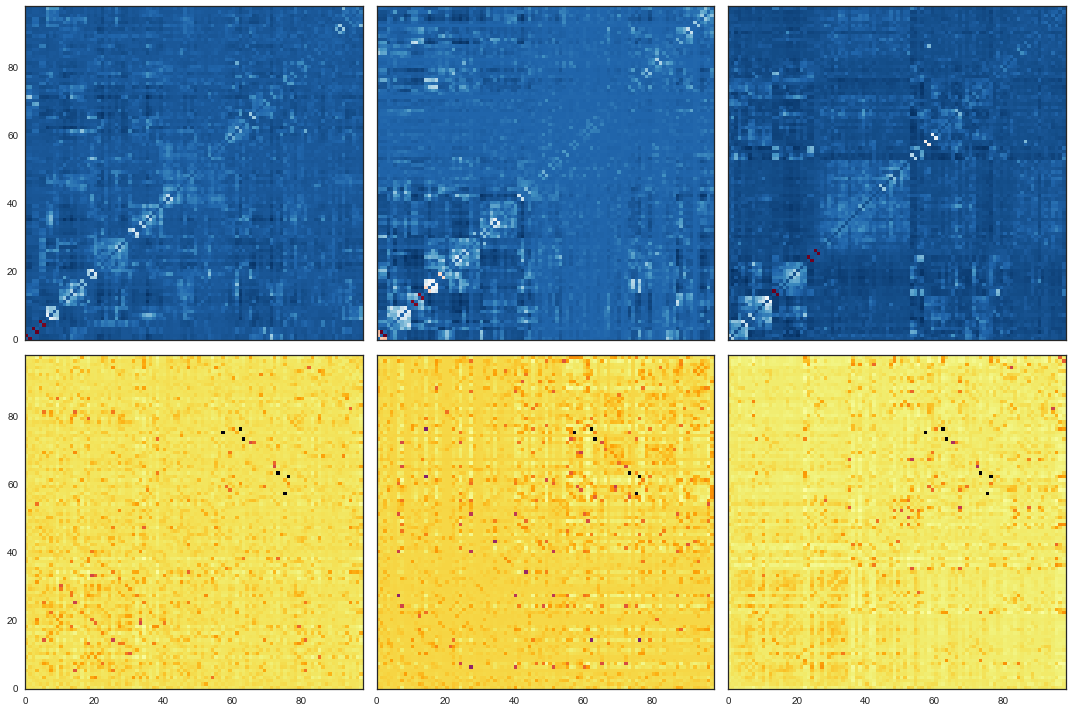

In [40]:
N = int(N)
sns.set_style('white')
f,axarr = pl.subplots(2,3,figsize=[15,10],sharex=True,sharey=True)
im1 = axarr[0,0].pcolormesh(CCC[0] - np.identity(N),cmap="RdBu_r");
im2 = axarr[0,1].pcolor(CCC[1] - np.identity(N),cmap="RdBu_r");
im3 = axarr[0,2].pcolor(CCC[2] - np.identity(N),cmap="RdBu_r");
im4 = axarr[1,0].pcolor(ThetaCorrMatrices[0] - np.identity(N),cmap='inferno_r');
im5 = axarr[1,1].pcolor(ThetaCorrMatrices[1] - np.identity(N),cmap='inferno_r');
im6 = axarr[1,2].pcolor(ThetaCorrMatrices[2] - np.identity(N),cmap='inferno_r')

axarr[0,0].set_xlim([0,N])
axarr[0,0].set_ylim([0,N])
#ax2.set_title('LinearTrack')
#ax3.set_title('Sleep POST')
#pl.colorbar(im3);
pl.tight_layout()

"\nax1.set_ylabel('EigVals PRE')\nax1.set_xlabel('#')\nax2.set_ylabel('EigVals LinearTrack')\nax2.set_xlabel('#')\nax3.set_ylabel('EigVals POST')\nax3.set_xlabel('#')\nax1.set_title('Sleep PRE')\nax2.set_title('LinearTrack')\nax3.set_title('Sleep POST')\nax2.yaxis.label.set_color('white')\nax2.tick_params(axis='y', colors='white')\nax3.yaxis.label.set_color('white')\nax3.tick_params(axis='y', colors='white')\n"

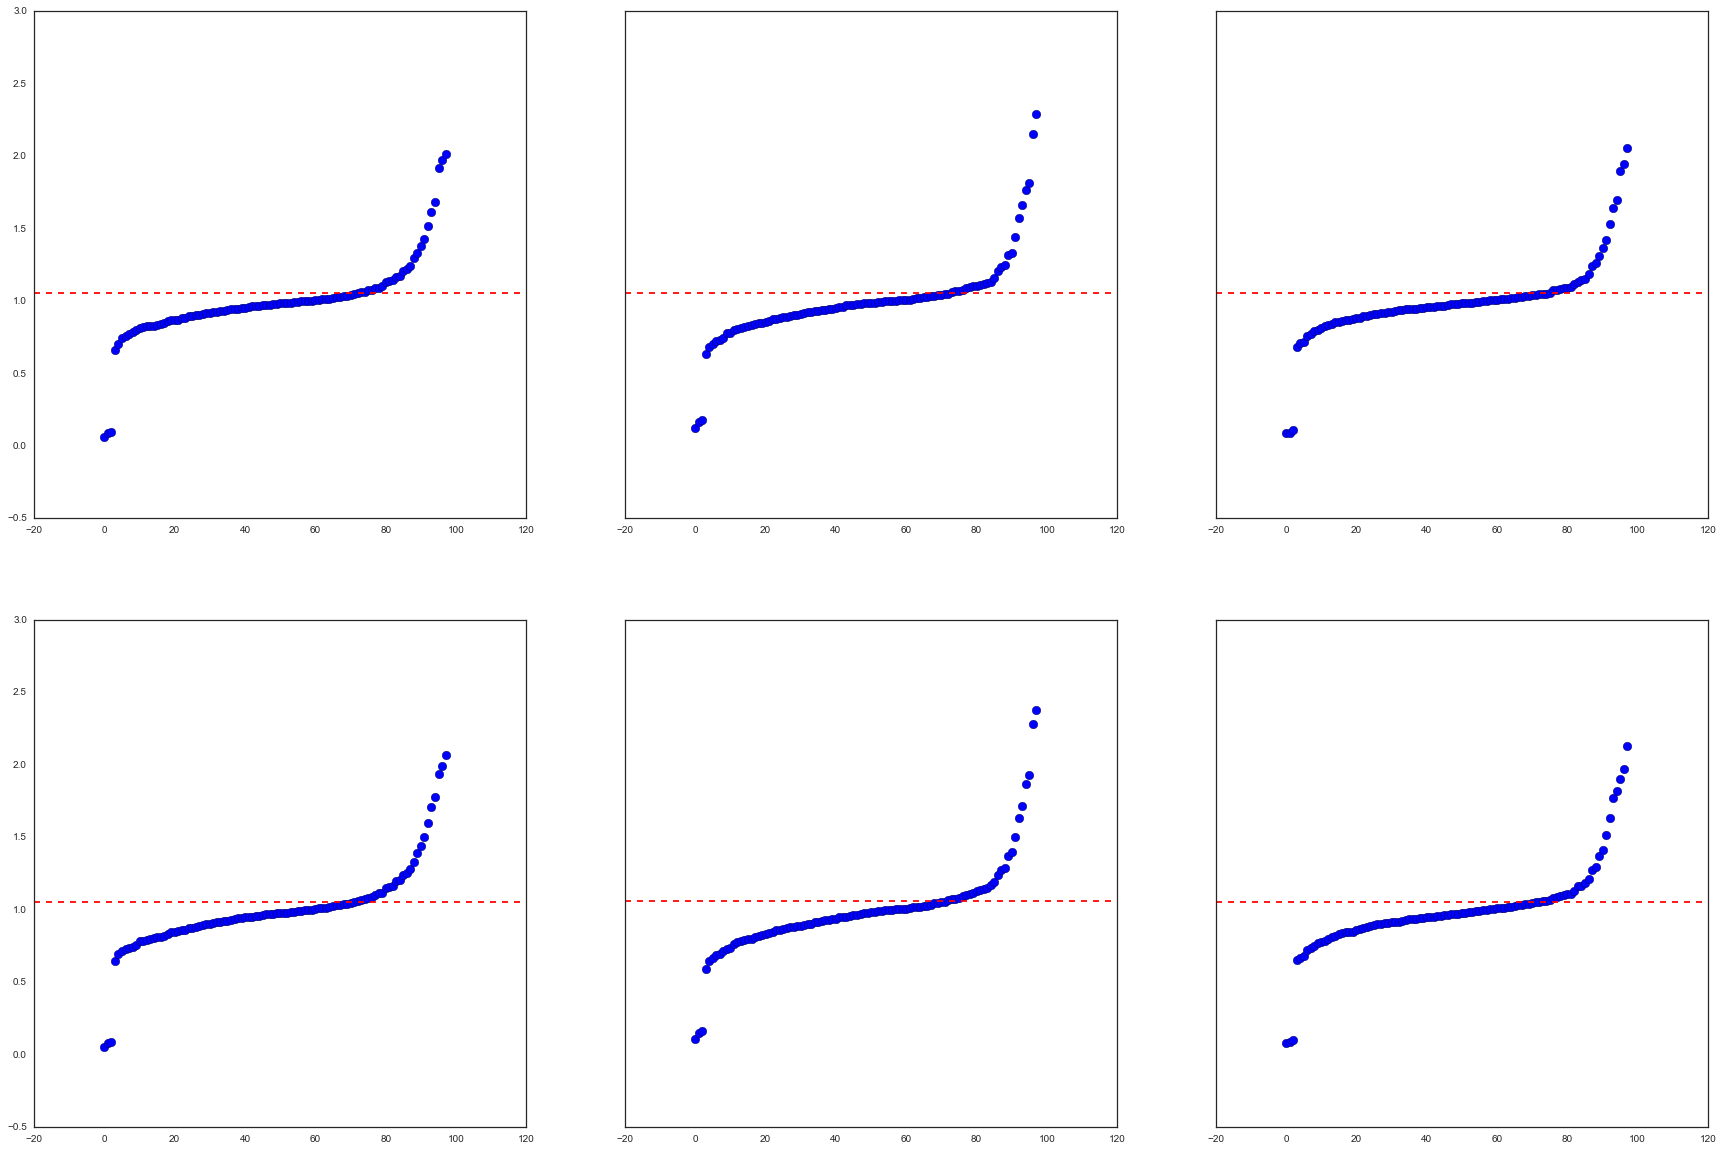

In [24]:
f,axarr = pl.subplots(2,3,figsize=[30,20],sharey=True)
axarr[0,0].scatter(range(eigVals[0].size),eigVals[0],s=75)
axarr[0,0].axhline(lMax[0]+TW_limit,color = 'r',linestyle='--')
axarr[0,1].scatter(range(eigVals[1].size),eigVals[1],s=75)
axarr[0,1].axhline(lMax[1]+TW_limit,color = 'r',linestyle='--')
axarr[0,2].scatter(range(eigVals[2].size),eigVals[2],s=75)
axarr[0,2].axhline(lMax[2]+TW_limit,color = 'r',linestyle='--')
############
axarr[1,0].scatter(range(ThetaEigVals[0].size),ThetaEigVals[0],s=75)
axarr[1,0].axhline(TlMax[0]+TW_limit,color = 'r',linestyle='--')
axarr[1,1].scatter(range(eigVals[1].size),ThetaEigVals[1],s=75)
axarr[1,1].axhline(TlMax[1]+TW_limit,color = 'r',linestyle='--')
axarr[1,2].scatter(range(eigVals[2].size),ThetaEigVals[2],s=75)
axarr[1,2].axhline(TlMax[2]+TW_limit,color = 'r',linestyle='--')
'''
ax1.set_ylabel('EigVals PRE')
ax1.set_xlabel('#')
ax2.set_ylabel('EigVals LinearTrack')
ax2.set_xlabel('#')
ax3.set_ylabel('EigVals POST')
ax3.set_xlabel('#')
ax1.set_title('Sleep PRE')
ax2.set_title('LinearTrack')
ax3.set_title('Sleep POST')
ax2.yaxis.label.set_color('white')
ax2.tick_params(axis='y', colors='white')
ax3.yaxis.label.set_color('white')
ax3.tick_params(axis='y', colors='white')
'''

In [25]:
Gamma = []
TGamma = []
for ii in range(3):
    G = []
    TG = []
    for jj in range(int(N)):
        G.append(eigVecs[1][jj].T.dot(corrMatrices[ii]).dot(eigVecs[1][jj]))
        TG.append(ThetaEigVecs[1][jj].T.dot(ThetaCorrMatrices[ii]).dot(ThetaEigVecs[1][jj]))
    Gamma.append(np.array(G))
    TGamma.append(np.array(TG))

In [26]:
TW_limit,np.where(eigVals[2]>lMax[2]+TW_limit),np.where(ThetaEigVals[2]>TlMax[2]+TW_limit)

(0.04704526830069076,
 (array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
         92, 93, 94, 95, 96, 97]),),
 (array([73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91, 92, 93, 94, 95, 96, 97]),))

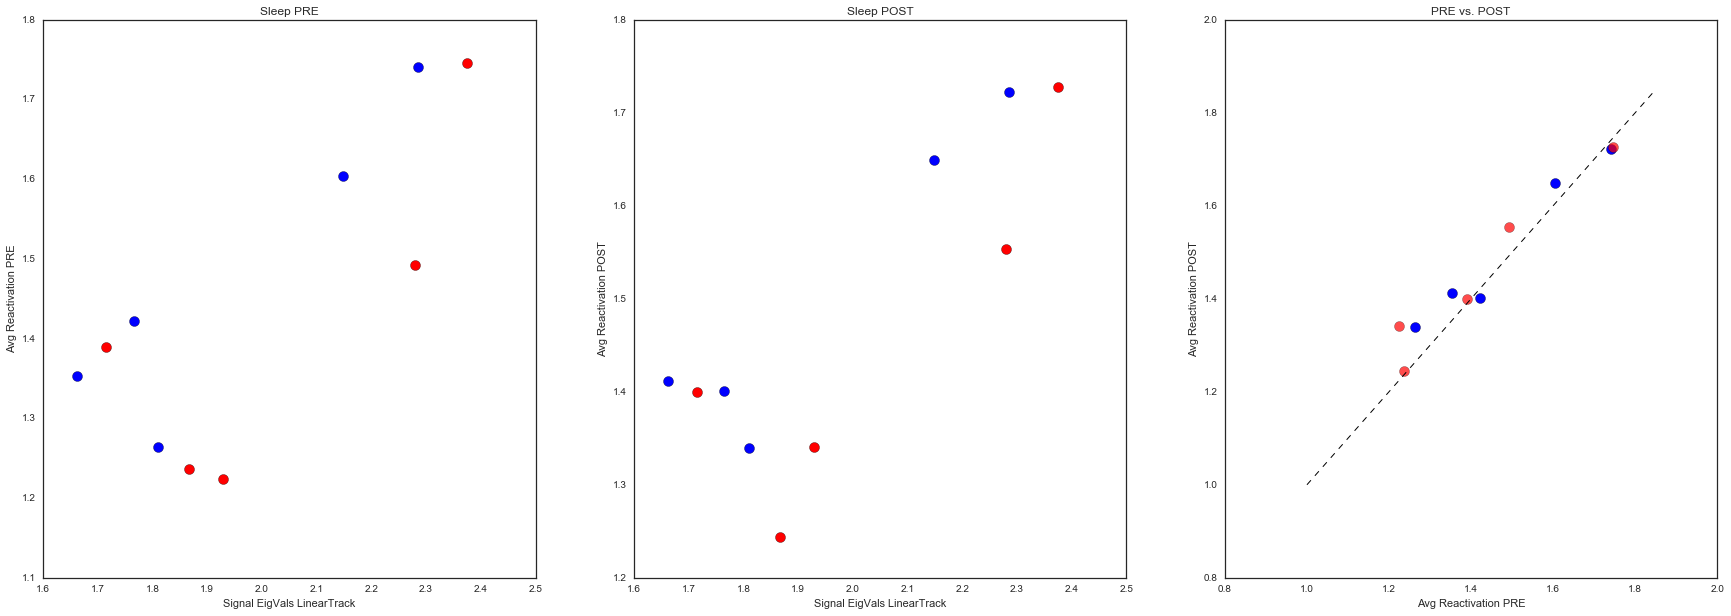

In [32]:
sigN = 93
f,(ax1,ax2,ax3) = pl.subplots(1,3,figsize=[30,10])
ax1.scatter(eigVals[1][sigN:],Gamma[0][sigN:],s=100)
ax1.scatter(ThetaEigVals[1][sigN:],TGamma[0][sigN:],c='r',s=100)
ax2.scatter(eigVals[1][sigN:],Gamma[2][sigN:],s=100)
ax2.scatter(ThetaEigVals[1][sigN:],TGamma[2][sigN:],c='r',s=100)
ax3.scatter(Gamma[0][sigN:],Gamma[2][sigN:],s=100)
ax3.scatter(TGamma[0][sigN:],TGamma[2][sigN:],c='r',s=100,alpha=0.7)
ax3.plot([1,1.85],[1,1.85],'k--', lw=1)
ax1.set_ylabel('Avg Reactivation PRE')
ax1.set_xlabel('Signal EigVals LinearTrack')
ax2.set_ylabel('Avg Reactivation POST')
ax2.set_xlabel('Signal EigVals LinearTrack')
ax3.set_ylabel('Avg Reactivation POST')
ax3.set_xlabel('Avg Reactivation PRE')
ax1.set_title('Sleep PRE')
ax2.set_title('Sleep POST')
ax3.set_title('PRE vs. POST')

In [33]:
reactivationStrengths  = np.array([Gamma[0][sigN:],Gamma[2][sigN:]])
TreactivationStrengths = np.array([TGamma[0][sigN:],TGamma[2][sigN:]])
pkl.dump(reactivationStrengths,open(WorkPath+'rat3906D3-25ms-vis.cnt','wb'),pkl.HIGHEST_PROTOCOL)
pkl.dump(TreactivationStrengths,open(WorkPath+'rat3906D3-4theta-vis.cnt','wb'),pkl.HIGHEST_PROTOCOL)

168441


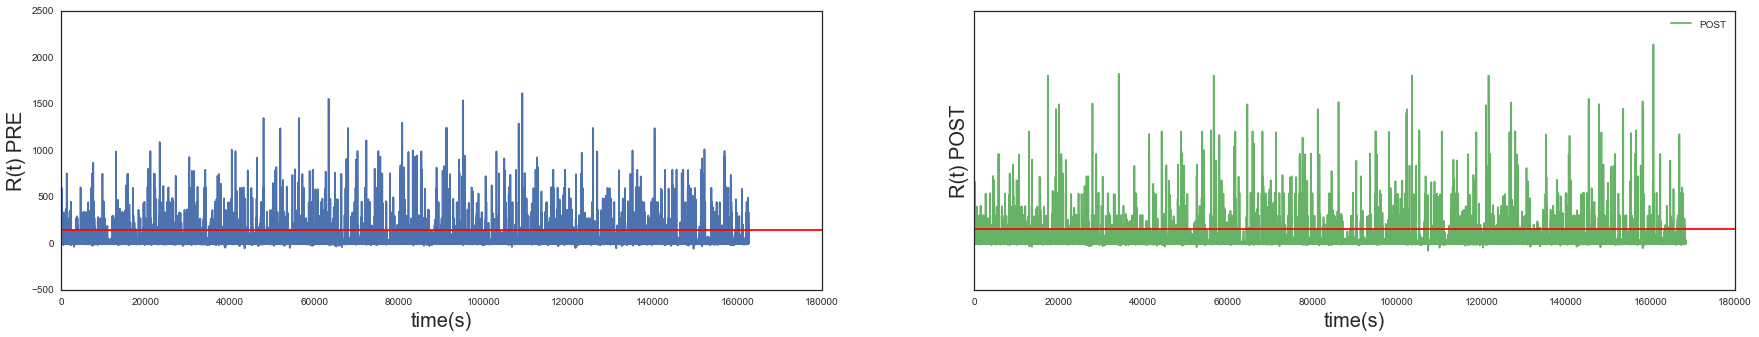

In [34]:
Tidx = 1
Rz = []
threshold = []
for Midx in [0,2]:
    R0 = 0
    for ii in range(N):
        for jj in range(N):
            if ii != jj:
                R0 += Qs[Midx][ii]*corrMatrices[Tidx][ii,jj]*Qs[Midx][jj]
    #print R0
    Rz.append(R0)        
    threshold.append(R0.mean()+3.50*R0.std())
#    R0pPeaksTimes = X[scsig.argrelmax(R0p)]
#    R0pPeaksValues = R0p[scsig.argrelmax(R0p)]
pkl.dump([sigN,Rz],open(WorkPath+'rat3906D3-25ms.R0','wb'),pkl.HIGHEST_PROTOCOL)
f,(ax1,ax2) = pl.subplots(1,2,figsize=[30,5],sharey=True)
ax1.plot(Rz[0],label = 'PRE')
ax2.plot(Rz[1],'g',alpha=0.6,label = 'POST')
ax1.axhline(threshold[0],color='r')
ax2.axhline(threshold[1],color='r')
ax1.set_ylabel('R(t) PRE',fontsize=20)
ax1.set_xlabel('time(s)',fontsize=20)
ax2.set_ylabel('R(t) POST',fontsize=20)
ax2.set_xlabel('time(s)',fontsize=20)
pl.legend()
print R0.size

124499


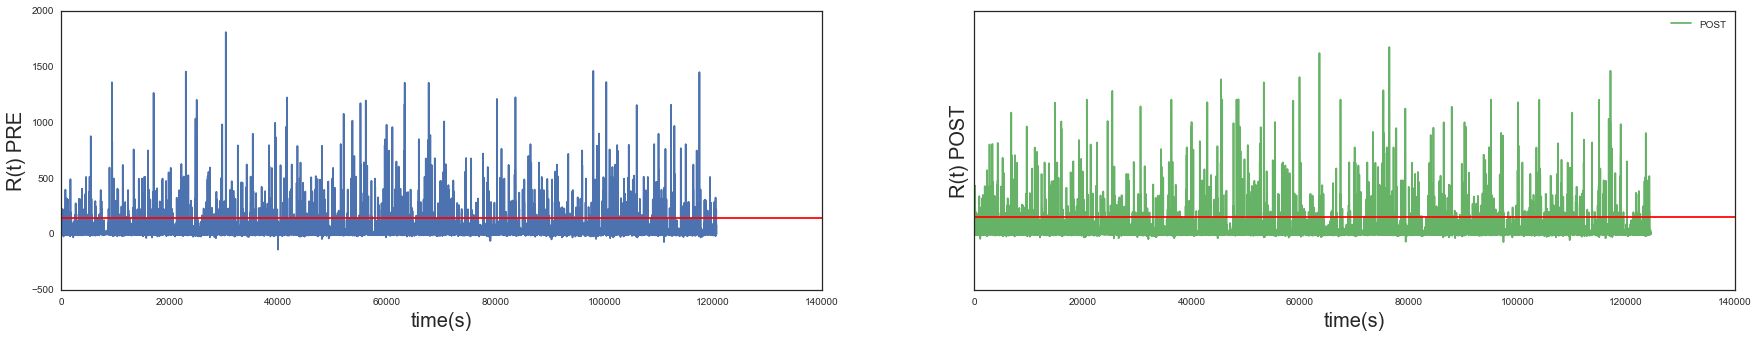

In [35]:
Tidx = 1
Rz = []
threshold = []
for Midx in [0,2]:
    R0 = 0
    for ii in range(N):
        for jj in range(N):
            if ii != jj:
                R0 += ThetaQs[Midx][ii]*ThetaCorrMatrices[Tidx][ii,jj]*ThetaQs[Midx][jj]
    #print R0
    Rz.append(R0)        
    threshold.append(R0.mean()+3.50*R0.std())
#    R0pPeaksTimes = X[scsig.argrelmax(R0p)]
#    R0pPeaksValues = R0p[scsig.argrelmax(R0p)]
pkl.dump([sigN,Rz],open(WorkPath+'rat3906D3-4theta.R0','wb'),pkl.HIGHEST_PROTOCOL)
f,(ax1,ax2) = pl.subplots(1,2,figsize=[30,5],sharey=True)
ax1.plot(Rz[0],label = 'PRE')
ax2.plot(Rz[1],'g',alpha=0.6,label = 'POST')
ax1.axhline(threshold[0],color='r')
ax2.axhline(threshold[1],color='r')
ax1.set_ylabel('R(t) PRE',fontsize=20)
ax1.set_xlabel('time(s)',fontsize=20)
ax2.set_ylabel('R(t) POST',fontsize=20)
ax2.set_xlabel('time(s)',fontsize=20)
pl.legend()
print R0.size

In [36]:
Tidx = 1
Rzl = []
for Midx in [0,2]:
    Ri = np.zeros(Qs[Midx][-10:].shape)
    for pIdx,pattern in enumerate(Ps[Tidx][-10:]):
        for ii in range(N):
            for jj in range(N):
                if ii != jj:
                    Ri[pIdx] += Qs[Midx][ii]*pattern[ii,jj]*Qs[Midx][jj]
    Rzl.append(Ri)        
pkl.dump([sigN,Rzl],open(WorkPath+'rat3906D3-25ms.Rl','wb'),pkl.HIGHEST_PROTOCOL)
#############################
Rzl = []
for Midx in [0,2]:
    Ri = np.zeros(ThetaQs[Midx][-10:].shape)
    for pIdx,pattern in enumerate(ThetaPs[Tidx][-10:]):
        for ii in range(N):
            for jj in range(N):
                if ii != jj:
                    Ri[pIdx] += ThetaQs[Midx][ii]*pattern[ii,jj]*ThetaQs[Midx][jj]
    Rzl.append(Ri)        
pkl.dump([sigN,Rzl],open(WorkPath+'rat3906D3-4theta.Rl','wb'),pkl.HIGHEST_PROTOCOL)

In [40]:
AAA = []
for ii in [0,1]:
    peakIdx = scsig.argrelmax(Rz[ii])
    sigPeaksIdx = np.where(Rz[ii][peakIdx]>threshold[ii])[0]
    sigPeaksVal = Rz[ii][sigPeaksIdx]
    A = sigPeaksIdx.size/1.0/Rz[ii].size
    B = Rz[ii][peakIdx].mean()
    Bs = Rz[ii][peakIdx].std()
    C = sigPeaksVal.mean()
    Cs = sigPeaksVal.std()
    AAA.append(np.array([A,B,Bs,C,Cs]))
print AAA[0]/AAA[1]
pkl.dump(AAA,open(WorkPath+'rat3906D3.rr','wb'),pkl.HIGHEST_PROTOCOL)

[ 0.91781791  0.89648974  0.9623808   1.82512244  1.54636903]
